In [74]:
# Install Miniconda
# https://docs.conda.io/en/latest/miniconda.html
# Python 3.7 is used

In [75]:
# Add conda channels
! conda config --add channels defaults
! conda config --add channels bioconda
! conda config --add channels conda-forge

In [76]:
# Install Gromacs
! printf "y" | conda install -c bioconda gromacs

Solving environment: done

# All requested packages already installed.



In [77]:
# Install additional libraries
! printf "y" | conda install numpy pandas matplotlib
! printf "y" | conda install nglview mdanalysis
! printf "y" | pip install GromacsWrapper pytraj

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [78]:
# Initialize and enable NGLview
! jupyter-nbextension enable --py --sys-prefix widgetsnbextension
! jupyter-nbextension enable nglview --py --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK


In [79]:
# numpy and matplotlib are required for result analysis and plotting

In [80]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# pytraj and nglview are required for trajectory analysis and visualization

In [82]:
import pytraj as pt
import nglview as nv

In [83]:
# GromacsWrapper can also be used instead of command line 

In [84]:
import gromacs
import gromacs.formats
gromacs.config.setup()

In [85]:
print(gromacs.release)

2021.1-MODIFIED


In [86]:
# update the gromacs location
import os
os.environ["GMXLIB"] = "/home/" + os.environ["USER"] + "/miniconda3/envs/md/share/gromacs/top"
print(os.environ["GMXLIB"])
%env GMXLIB

/home/felix/miniconda3/envs/md/share/gromacs/top


'/home/felix/miniconda3/envs/md/share/gromacs/top'

# Generate Topology

In [87]:
# Remove water molecules
! grep -v HOH data/1aki.pdb > data/prot_clean.pdb

In [91]:
# Prepare .gro input file
! gmx pdb2gmx -f data/prot_clean.pdb -o prot_pros.gro -water spce -ff amber99sb

                 :-) GROMACS - gmx pdb2gmx, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Tee

In [95]:
! tail topol.top

#include "amber99sb.ff/ions.itp"

[ system ]
; Name
LYSOZYME in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
SOL             10644


## Generate box and solvate protein

In [93]:
! gmx editconf -f prot_pros.gro -o prot_box.gro -c -d 1.0 -bt cubic

                :-) GROMACS - gmx editconf, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Tee

In [94]:
! gmx solvate -cp prot_box.gro -cs spc216.gro -o prot_solv.gro -p topol.top

                 :-) GROMACS - gmx solvate, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Tee

## Adding ions

In [97]:
! gmx grompp -f data/ions.mdp -c prot_solv.gro -p topol.top -o ions.tpr

                 :-) GROMACS - gmx grompp, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [100]:
! printf "SOL" | gmx genion -s ions.tpr -o prot_solv_ions.gro -p topol.top -pname NA -nname CL -neutral

                 :-) GROMACS - gmx genion, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [101]:
! tail topol.top


[ system ]
; Name
LYSOZYME in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
SOL         10636
CL               8


## Energy minimization

In [102]:
! gmx grompp -f data/minim.mdp -c prot_solv_ions.gro -p topol.top -o em.tpr

                 :-) GROMACS - gmx grompp, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [103]:
# nt is used to define the number of cores
! gmx mdrun -v -deffnm em -nt 4

                  :-) GROMACS - gmx mdrun, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

Step=   92, Dmax= 2.3e-02 nm, Epot= -5.33897e+05 Fmax= 1.86679e+04, atom= 1015
Step=   94, Dmax= 1.4e-02 nm, Epot= -5.34536e+05 Fmax= 2.56004e+03, atom= 1015
Step=   95, Dmax= 1.7e-02 nm, Epot= -5.35072e+05 Fmax= 2.26210e+04, atom= 1015
Step=   96, Dmax= 2.0e-02 nm, Epot= -5.35848e+05 Fmax= 8.06117e+03, atom= 1015
Step=   98, Dmax= 1.2e-02 nm, Epot= -5.36062e+05 Fmax= 1.02152e+04, atom= 1015
Step=   99, Dmax= 1.4e-02 nm, Epot= -5.36266e+05 Fmax= 1.18499e+04, atom= 1015
Step=  100, Dmax= 1.7e-02 nm, Epot= -5.36430e+05 Fmax= 1.44701e+04, atom= 1015
Step=  101, Dmax= 2.1e-02 nm, Epot= -5.36567e+05 Fmax= 1.72204e+04, atom= 1015
Step=  102, Dmax= 2.5e-02 nm, Epot= -5.36644e+05 Fmax= 2.06181e+04, atom= 1015
Step=  104, Dmax= 1.5e-02 nm, Epot= -5.37317e+05 Fmax= 2.19722e+03, atom= 1015
Step=  105, Dmax= 1.8e-02 nm, Epot= -5.37914e+05 Fmax= 2.47884e+04, atom= 1015
Step=  106, Dmax= 2.1e-02 nm, Epot= -5.38732e+05 Fmax= 8.23894e+03, atom= 1015
Step=  108, Dmax= 1.3e-02 nm, Epot= -5.38901e+05 Fma

Step=  225, Dmax= 1.8e-02 nm, Epot= -5.56192e+05 Fmax= 1.62268e+04, atom= 1958
Step=  226, Dmax= 2.1e-02 nm, Epot= -5.56276e+05 Fmax= 1.62348e+04, atom= 1958
Step=  228, Dmax= 1.3e-02 nm, Epot= -5.56513e+05 Fmax= 3.33369e+03, atom= 1958
Step=  229, Dmax= 1.5e-02 nm, Epot= -5.56534e+05 Fmax= 1.98748e+04, atom= 1958
Step=  230, Dmax= 1.8e-02 nm, Epot= -5.56830e+05 Fmax= 8.34837e+03, atom= 1958
Step=  232, Dmax= 1.1e-02 nm, Epot= -5.56912e+05 Fmax= 8.46542e+03, atom= 1958
Step=  233, Dmax= 1.3e-02 nm, Epot= -5.56963e+05 Fmax= 1.18935e+04, atom= 1958
Step=  234, Dmax= 1.6e-02 nm, Epot= -5.57038e+05 Fmax= 1.23458e+04, atom= 1958
Step=  235, Dmax= 1.9e-02 nm, Epot= -5.57042e+05 Fmax= 1.68957e+04, atom= 1958
Step=  236, Dmax= 2.3e-02 nm, Epot= -5.57098e+05 Fmax= 1.79786e+04, atom= 1958
Step=  238, Dmax= 1.4e-02 nm, Epot= -5.57371e+05 Fmax= 3.04359e+03, atom= 1958
Step=  239, Dmax= 1.6e-02 nm, Epot= -5.57377e+05 Fmax= 2.18684e+04, atom= 1958
Step=  240, Dmax= 2.0e-02 nm, Epot= -5.57719e+05 Fma

Step=  357, Dmax= 1.1e-02 nm, Epot= -5.65962e+05 Fmax= 9.68162e+03, atom= 1958
Step=  358, Dmax= 1.4e-02 nm, Epot= -5.66000e+05 Fmax= 1.11081e+04, atom= 1958
Step=  359, Dmax= 1.6e-02 nm, Epot= -5.66021e+05 Fmax= 1.39241e+04, atom= 1958
Step=  360, Dmax= 2.0e-02 nm, Epot= -5.66042e+05 Fmax= 1.59932e+04, atom= 1958
Step=  362, Dmax= 1.2e-02 nm, Epot= -5.66203e+05 Fmax= 2.01891e+03, atom= 1958
Step=  363, Dmax= 1.4e-02 nm, Epot= -5.66278e+05 Fmax= 1.93375e+04, atom= 1958
Step=  364, Dmax= 1.7e-02 nm, Epot= -5.66482e+05 Fmax= 6.66388e+03, atom= 1958
Step=  366, Dmax= 1.0e-02 nm, Epot= -5.66522e+05 Fmax= 8.85127e+03, atom= 1958
Step=  367, Dmax= 1.2e-02 nm, Epot= -5.66564e+05 Fmax= 9.86284e+03, atom= 1958
Step=  368, Dmax= 1.5e-02 nm, Epot= -5.66588e+05 Fmax= 1.24863e+04, atom= 1958
Step=  369, Dmax= 1.7e-02 nm, Epot= -5.66615e+05 Fmax= 1.44080e+04, atom= 1958
Step=  371, Dmax= 1.0e-02 nm, Epot= -5.66749e+05 Fmax= 1.69719e+03, atom= 1958
Step=  372, Dmax= 1.3e-02 nm, Epot= -5.66862e+05 Fma

Step=  490, Dmax= 8.7e-03 nm, Epot= -5.72305e+05 Fmax= 7.70902e+03, atom= 1958
Step=  491, Dmax= 1.0e-02 nm, Epot= -5.72338e+05 Fmax= 8.28100e+03, atom= 1958
Step=  492, Dmax= 1.2e-02 nm, Epot= -5.72353e+05 Fmax= 1.09466e+04, atom= 1958
Step=  493, Dmax= 1.5e-02 nm, Epot= -5.72376e+05 Fmax= 1.20655e+04, atom= 1958
Step=  495, Dmax= 9.0e-03 nm, Epot= -5.72468e+05 Fmax= 1.77492e+03, atom= 1958
Step=  496, Dmax= 1.1e-02 nm, Epot= -5.72525e+05 Fmax= 1.47323e+04, atom= 1958
Step=  497, Dmax= 1.3e-02 nm, Epot= -5.72644e+05 Fmax= 5.23214e+03, atom= 1958
Step=  499, Dmax= 7.8e-03 nm, Epot= -5.72674e+05 Fmax= 6.69486e+03, atom= 1958
Step=  500, Dmax= 9.3e-03 nm, Epot= -5.72704e+05 Fmax= 7.67768e+03, atom= 1958
Step=  501, Dmax= 1.1e-02 nm, Epot= -5.72727e+05 Fmax= 9.50170e+03, atom= 1958
Step=  502, Dmax= 1.3e-02 nm, Epot= -5.72747e+05 Fmax= 1.11719e+04, atom= 1958
Step=  503, Dmax= 1.6e-02 nm, Epot= -5.72756e+05 Fmax= 1.35530e+04, atom= 1958
Step=  505, Dmax= 9.7e-03 nm, Epot= -5.72866e+05 Fma

Step=  620, Dmax= 9.2e-03 nm, Epot= -5.76896e+05 Fmax= 1.38115e+03, atom= 1958
Step=  621, Dmax= 1.1e-02 nm, Epot= -5.76932e+05 Fmax= 1.59726e+04, atom= 1958
Step=  622, Dmax= 1.3e-02 nm, Epot= -5.77065e+05 Fmax= 4.54444e+03, atom= 1958
Step=  624, Dmax= 8.0e-03 nm, Epot= -5.77079e+05 Fmax= 7.83086e+03, atom= 1958
Step=  625, Dmax= 9.6e-03 nm, Epot= -5.77110e+05 Fmax= 6.90296e+03, atom= 1958
Step=  627, Dmax= 5.8e-03 nm, Epot= -5.77148e+05 Fmax= 1.98958e+03, atom= 1958
Step=  628, Dmax= 6.9e-03 nm, Epot= -5.77182e+05 Fmax= 8.54126e+03, atom= 1958
Step=  629, Dmax= 8.3e-03 nm, Epot= -5.77230e+05 Fmax= 4.26102e+03, atom= 1958
Step=  631, Dmax= 5.0e-03 nm, Epot= -5.77256e+05 Fmax= 3.36211e+03, atom= 1958
Step=  632, Dmax= 6.0e-03 nm, Epot= -5.77279e+05 Fmax= 5.88673e+03, atom= 1958
Step=  633, Dmax= 7.2e-03 nm, Epot= -5.77307e+05 Fmax= 5.10508e+03, atom= 1958
Step=  634, Dmax= 8.6e-03 nm, Epot= -5.77319e+05 Fmax= 8.18264e+03, atom= 1958
Step=  635, Dmax= 1.0e-02 nm, Epot= -5.77349e+05 Fma

Step=  751, Dmax= 1.2e-02 nm, Epot= -5.80308e+05 Fmax= 9.93608e+03, atom= 1958
Step=  752, Dmax= 1.4e-02 nm, Epot= -5.80309e+05 Fmax= 1.19569e+04, atom= 1958
Step=  754, Dmax= 8.5e-03 nm, Epot= -5.80391e+05 Fmax= 1.15320e+03, atom= 1958
Step=  755, Dmax= 1.0e-02 nm, Epot= -5.80422e+05 Fmax= 1.47282e+04, atom= 1958
Step=  756, Dmax= 1.2e-02 nm, Epot= -5.80533e+05 Fmax= 4.19176e+03, atom= 1958
Step=  758, Dmax= 7.4e-03 nm, Epot= -5.80544e+05 Fmax= 7.19220e+03, atom= 1958
Step=  759, Dmax= 8.8e-03 nm, Epot= -5.80568e+05 Fmax= 6.40047e+03, atom= 1958
Step=  761, Dmax= 5.3e-03 nm, Epot= -5.80600e+05 Fmax= 1.78528e+03, atom= 1958
Step=  762, Dmax= 6.4e-03 nm, Epot= -5.80624e+05 Fmax= 7.95447e+03, atom= 1958
Step=  763, Dmax= 7.6e-03 nm, Epot= -5.80663e+05 Fmax= 3.83081e+03, atom= 1958
Step=  765, Dmax= 4.6e-03 nm, Epot= -5.80683e+05 Fmax= 3.20470e+03, atom= 1958
Step=  766, Dmax= 5.5e-03 nm, Epot= -5.80700e+05 Fmax= 5.29788e+03, atom= 1958
Step=  767, Dmax= 6.6e-03 nm, Epot= -5.80722e+05 Fma

In [104]:
! printf "10 0" | gmx energy -f em.edr  -o potential.xvg
# 10 is the potential, maybe the number is different in a different version of gromacs

                 :-) GROMACS - gmx energy, 2021.1-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [110]:
! cat potential.xvg

# This file was created Sun Jun 20 14:31:14 2021
# Created by:
#                 :-) GROMACS - gmx energy, 2021.1-MODIFIED (-:
# 
# Executable:   /home/felix/miniconda3/envs/md/bin.AVX2_256/gmx
# Data prefix:  /home/felix/miniconda3/envs/md
# Working dir:  /home/felix/calculations/mdtutorials
# Command line:
#   gmx energy -f em.edr -o potential.xvg
# gmx energy is part of G R O M A C S:
#
# Georgetown Riga Oslo Madrid Amsterdam Chisinau Stockholm
#
@    title "GROMACS Energies"
@    xaxis  label "Time (ps)"
@    yaxis  label "(kJ/mol)"
@TYPE xy
@ view 0.15, 0.15, 0.75, 0.85
@ legend on
@ legend box on
@ legend loctype view
@ legend 0.78, 0.8
@ legend length 2
@ s0 legend "Potential"
    0.000000  -327858.750000
    1.000000  -348302.500000
    2.000000  -372925.406250
    3.000000  -401599.562500
    4.000000  -424771.187500
    5.000000  -443443.125000
    6.000000  -461835.031250
    7.000000  -468435.781250
    8.000000  -468723.218750
    9.000000  -476394.406250
   10.000000  -47

[[ 0.00000000e+00 -3.27858750e+05]
 [ 1.00000000e+00 -3.48302500e+05]
 [ 2.00000000e+00 -3.72925406e+05]
 ...
 [ 7.98000000e+02 -5.81358375e+05]
 [ 7.99000000e+02 -5.81362062e+05]
 [ 8.01000000e+02 -5.81421688e+05]]


Text(0, 0.5, 'potential')

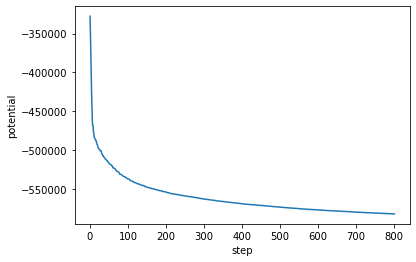

In [113]:
# generate graph
potential = np.genfromtxt([i for i in open('potential.xvg').read().splitlines()
                          if not i.startswith(('#', '@'))])
print(potential)
plt.plot(*potential.T)
plt.xlabel('step')
plt.ylabel('potential')

## Equilibration Steps - NVT

In [ ]:
! gmx grompp -f data/nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr